# Scripts to run and their commands

## Creating environment with Conda

```shell
conda create -y -n lnc -c rapidsai -c conda-forge -c nvidia rapids=24.02 python=3.9 cuda-version=12.0 pytorch ipykernel
```

Addings rapids AI is not necessary but I typically like adding it since it lets you use additional CUDA libraries that are created for Python. This also requires Conda (or mini-Conda which I have installed) and the latest NVIDIA drivers to be installed. I highly recommend installing the latest NVIDIA drivers available for your machine as Conda allows you to create environments with the newest CUDA version that comes with your local drivers, and older. For example, I set up my machine to have CUDA 12.0 but Conda still lets me create an environment with version 11.2. But if I had CUDA 11.2, then Conda would not let me create an environment with version 12.0. 

If your drivers are properly installed, then you can check what processes are allocating GPU memory as well as which driver version and CUDA version you have by typing:
```shell
nvidia-smi
```

One more final check to see if PyTorch and the correct version of CUDA is properly setup with your environment is to run
```shell
conda activate lnc
python3
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the CUDA version
    cuda_version = torch.version.cuda
    print("CUDA version:", cuda_version)
else:
    print("CUDA is not available.")

```

Finally, in your 'lnc' environment and in a directory of your choosing, set up autoLiRPA with the following commands:

```shell
git clone https://github.com/Verified-Intelligence/auto_LiRPA
cd auto_LiRPA
python setup.py install
python auto_LiRPA/cuda_utils.py install
```

```shell
pip install skl2onnx onnxoptimizer onnxruntime onnx2pytorch
```

## Start up 
```shell
cd ~/Documents/Research/neural_lyapunov_training
conda activate lnc
```

## add complete verifier path
```shell
export PYTHONPATH=/home/jorgejc2/Documents/Research/neural_copy/neural_lyapunov_training:/home/jorgejc2/Documents/Research/Verifier_Development
```

## Running Bisection
```shell
python3 -u -m neural_lyapunov_training.bisect \
--lower_limit -12 -12 --upper_limit 12 12 --hole_size 0.001 \
--init_rho 603.5202 --rho_eps 0.1 \
--config ~/Documents/Research/neural_lyapunov_training/pendulum_state_feedback_lyapunov_in_levelset.yaml \
--timeout 100
```
```shell
python3 -u -m neural_lyapunov_training.bisect --lower_limit -6 -6 --upper_limit 6 6 --hole_size 0.05 --init_rho 1.0 --rho_eps 0.1 --config ~/Documents/Research/neural_copy/neural_lyapunov_training/StabilityAnalysis.yaml --timeout 100
```

## running verification
```shell
cd ~/Documents/Research/Verifier_Development/complete_verifier
python abcrown.py --config ~/Documents/Research/neural_lyapunov_training/pendulum_state_feedback_lyapunov_in_levelset.yaml
```

## Generate VNNLib files
```shell
python -m neural_lyapunov_training.generate_vnnlib \
--lower_limit -12 -12 --upper_limit 12 12 --hole_size 0.001 \
--value_levelset 708.3 \
specs/pendulum_state_feedback --check_x_next
```
```shell
python -m neural_lyapunov_training.generate_vnnlib \
--lower_limit -6 -6 --upper_limit 6 6 --hole_size 0.05 \
--value_levelset 8 \
specs/StabilityAnalysis --check_x_next
```
## YAML File Changes

The most relevant yaml file will be the pendulum_state_feedback_lyapunov_in_levelset.yaml file as well as the cifar_resnet_2b.yaml file. The former is on this Github, while the latter can be found at the following [link](https://github.com/Verified-Intelligence/alpha-beta-CROWN/blob/main/complete_verifier/exp_configs/tutorial_examples/cifar_resnet_2b.yaml).

In [1]:
import numpy as np
from numpy import genfromtxt, loadtxt
import matplotlib.pyplot as plt

$x_1 :=$ x1; the state input to the neural network controller. 

$\delta_{v_1} := $ deltav1; Recall that their approach calculates the lower and upper bound to the input of some activation function denoted as $\phi(v)$. Thus, $v_1$ is the input to the linear function. $v_1$ is equivalent to $v_1 = W^{(1)}x_1 + b^{(1)}$. In their neural network for the inverted pendulum with input control saturation, all biases are 0. Let $v_1^* := \bar{v_1} - \frac{(\bar{v_1} - \underline{v_1})}{2}$, then $\underline{v_1} = v_1^* - \delta_{v_1}$ and $\bar{v_1} = v_1^* + \delta_{v_1}$. 

In [2]:
## variables

MATLAB_VARS_PATH = "./jorgejc2_matlab_vars/"

x1 = np.linspace(-10, 10, int(1e3))
n1 = 32
nG = 2 # Lyapunov function P should be nG x nG dimension
deltav1 = 0.100 
x1bound = 0.7300
domain1 = np.array([-10, 10, -10, 10])

# Lyapunov function
P = np.loadtxt(MATLAB_VARS_PATH + "mat_P.csv")
W1 = np.genfromtxt("./Wb_s32_tanh/W1.csv",delimiter=',', dtype=np.float32)

print(f"full P: \n{P}")
print(f"P: \n{P[:nG,:nG]}")

R = np.linalg.cholesky(P[:nG,:nG])
print(f"R@R.T: \n{R@R.T}")
print(f"R: \n{R}")

full P: 
[[2.41495073e+00 5.76426967e-01 2.05241835e-06]
 [5.76426967e-01 1.47226968e+00 3.28691004e-06]
 [2.05241835e-06 3.28691004e-06 2.62889476e-05]]
P: 
[[2.41495073 0.57642697]
 [0.57642697 1.47226968]]
R@R.T: 
[[2.41495073 0.57642697]
 [0.57642697 1.47226968]]
R: 
[[1.55401118 0.        ]
 [0.37092846 1.15528428]]


Z shape (300, 300) 
max: [array([-15., -15.]), 1134.0167278162778]


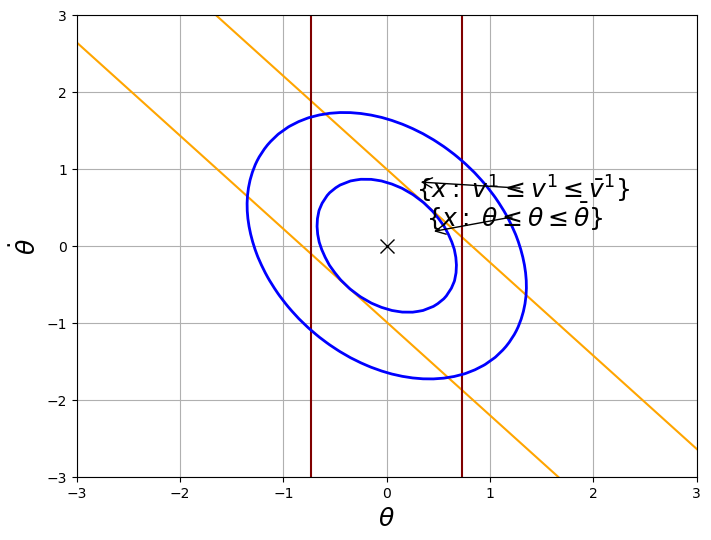

In [3]:
fig, ax = plt.subplots(figsize=(8,6))

# plots diagonal orange lines
for i in range(n1):
    plt.plot(x1, (deltav1-W1[i,0]*x1) / W1[i,1], color="orange")
    plt.plot(x1, (-deltav1-W1[i,0]*x1) / W1[i,1], color="orange")
    break

# plots vertical maroon lines
plt.plot([x1bound, x1bound], [-9,9], color="maroon")
plt.plot([-x1bound, -x1bound], [-9,9], color="maroon")

# Define ROA function
def V(x1, x2):
    ret = np.zeros(x1.shape)
    for i in range(x1.shape[0]):
        for j in range(x1.shape[1]):
            input = np.array([x1[i,j], x2[i,j]]).reshape(-1, 1)
            ret[i,j] = input.T @ P[:nG, :nG] @ input

    max_idx = np.unravel_index(np.argmax(ret), ret.shape)
    # print(f"max_idx {max_idx}")
    max_x = np.array([x1[max_idx], x2[max_idx]])
    max_val = ret[max_idx]
    max = [max_x, max_val]

    min_idx = np.unravel_index(np.argmin(ret), ret.shape)
    # print(f"min_idx {min_idx}")
    min_x = np.array([x1[min_idx], x2[min_idx]])
    min_val = ret[min_idx]
    min = [min_x, min_val]

    return ret, max

# Create meshgrid for contour plot
X, Y = np.meshgrid(np.linspace(-15, 15, 300), np.linspace(-15, 15, 300))
Z, max = V(X, Y)
print(f"Z shape {Z.shape} \nmax: {max}")

# Plot ROA contour
contour = ax.contour(X, Y, Z, levels=[1, 4], colors='blue', linewidths=2)

# Plot xeq
xeq = np.array([0, 0])  # Example value for xeq, replace with your desired value
ax.plot(xeq[0], xeq[1], 'kx', markersize=10)

# Annotations
plt.annotate(r"$\{x: \; v^1 \leq v^1 \leq \bar{v}^1\}$", xy=(0.3018, 0.8286), xytext=(0.2786, 0.6262),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=18)
plt.annotate(r"$\{x: \; \theta \leq \theta \leq \bar{\theta}\}$", xy=(0.43, 0.18), xytext=(0.38, 0.25),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=18)

# Formatting
plt.grid(True)
plt.axis([-3, 3, -3, 3])
plt.xlabel(r"$\theta$", fontsize=18)
plt.ylabel(r"$\dot{\theta}$", fontsize=18)

plt.show()

Here, I will create a NeuralNetworkController module that is specified under ./neural_lyapunov_training/controllers.py

The intention is to initialize this generic controller but upload the weights from the StabilityAnalysis paper. 

In [21]:
from neural_lyapunov_training.models import create_stability_analysis_model
import torch
import torch.nn as nn

In [22]:
def get_baseline_parameters(param_dir='Wb_s32_tanh', dtype="float64"):
    if dtype == "float64":
        np_dtype = np.float64
        torch_dtype = torch.float64
    elif dtype == "float32":
        np_dtype = np.float32
        torch_dtype = torch.float32
    W1 = torch.from_numpy(genfromtxt(param_dir+'/W1.csv',delimiter=',', dtype=np_dtype)).to(torch_dtype)
    W2 = torch.from_numpy(genfromtxt(param_dir+'/W2.csv',delimiter=',', dtype=np_dtype)).to(torch_dtype)
    W3 = torch.from_numpy(genfromtxt(param_dir+'/W3.csv',delimiter=',', dtype=np_dtype)).to(torch_dtype)

    weights = [W1, W2, W3]
    weights = [weight if len(weight.shape) == 2 else weight.unsqueeze(0) for weight in weights]


    return weights

In [23]:
from neural_lyapunov_training.models import create_pendulum_model_state_feedback
s_net = create_pendulum_model_state_feedback(
    lyapunov_parameters={"hidden_widths": [16,16,8], "R_rows": 3, "absolute_output": True, "eps": 0.01, "activation": torch.nn.LeakyReLU, "V_psd_form": "L1"},
    controller_parameters={"nlayer": 4, "hidden_dim": 8, "clip_output":"clamp", "u_lo": torch.tensor([-6]), "u_up": torch.tensor([6])},
    loss_parameters={"kappa": 0},
    loss_func="lyapunov.LyapunovDerivativeSimpleLossWithVBox"
)
for name, param in s_net.named_parameters():
    print(f"name: {name}, param shape: {param.shape}")

name: controller.net.0.weight, param shape: torch.Size([8, 2])
name: controller.net.0.bias, param shape: torch.Size([8])
name: controller.net.2.weight, param shape: torch.Size([8, 8])
name: controller.net.2.bias, param shape: torch.Size([8])
name: controller.net.4.weight, param shape: torch.Size([8, 8])
name: controller.net.4.bias, param shape: torch.Size([8])
name: controller.net.6.weight, param shape: torch.Size([1, 8])
name: controller.net.6.bias, param shape: torch.Size([1])
name: lyapunov.R, param shape: torch.Size([3, 2])
name: lyapunov.net.0.weight, param shape: torch.Size([16, 2])
name: lyapunov.net.0.bias, param shape: torch.Size([16])
name: lyapunov.net.2.weight, param shape: torch.Size([16, 16])
name: lyapunov.net.2.bias, param shape: torch.Size([16])
name: lyapunov.net.4.weight, param shape: torch.Size([8, 16])
name: lyapunov.net.4.bias, param shape: torch.Size([8])
name: lyapunov.net.6.weight, param shape: torch.Size([1, 8])
name: lyapunov.net.6.bias, param shape: torch.Si

In [24]:
s_net = create_stability_analysis_model(loss_parameters={"kappa": 0},
    loss_func="lyapunov.LyapunovDerivativeSimpleLossWithVBox")
# s_net.eval()
# print(type(s_net))
# x_out = s_net.forward(torch.rand(1,2))
# print(f"x_out: {x_out}")

# original dimensions
for name, param in s_net.named_parameters():
    print(f"name: {name}, param shape: {param.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/jorgejc2_matlab_vars/mat_P.csv'

In [ ]:
Weights = get_baseline_parameters('./Wb_s32_tanh')
W_count = 0
for name, param in s_net.named_parameters():
    if name in [f"controller.net.{i}.weight" for i in (0,2,4)]:
        param = Weights[W_count]
        print(param)
        print(f"name: {name}, param shape: {param.shape}")
        W_count += 1

    if name in [f"controller.net.{i}.bias" for i in (0,2,4)]:
        param = nn.Parameter(torch.zeros(param.shape))
        print(f"name: {name}, param shape: {param.shape}")
# save the model as a .pth file
torch.save(s_net.state_dict(), "./models/StabilityAnalysis_total_loss.pth")

tensor([[-0.1220, -0.1007],
        [ 0.1208,  0.0991],
        [ 0.1211,  0.0994],
        [ 0.1218,  0.1003],
        [ 0.1215,  0.1001],
        [ 0.1217,  0.1003],
        [-0.1205, -0.0987],
        [ 0.1215,  0.1000],
        [-0.1218, -0.1003],
        [ 0.1212,  0.0997],
        [ 0.1215,  0.1000],
        [-0.1209, -0.0993],
        [ 0.1217,  0.1003],
        [ 0.1206,  0.0989],
        [ 0.1209,  0.0992],
        [-0.1207, -0.0992],
        [ 0.1210,  0.0994],
        [-0.1210, -0.0994],
        [-0.1218, -0.1003],
        [-0.1218, -0.1003],
        [ 0.1205,  0.0987],
        [-0.1210, -0.0994],
        [-0.1214, -0.0999],
        [ 0.1214,  0.0997],
        [-0.1202, -0.0983],
        [-0.1213, -0.0998],
        [-0.1214, -0.1000],
        [-0.1207, -0.0989],
        [ 0.1214,  0.0998],
        [-0.1218, -0.1005],
        [-0.1212, -0.0998],
        [-0.1215, -0.1001]], dtype=torch.float64)
name: controller.net.0.weight, param shape: torch.Size([32, 2])
name: controller.n

In [ ]:
# last check of dimensions
for name, param in s_net.named_parameters():
    print(f"name: {name}, param shape: {param.shape}")

# x_out = s_net.forward(torch.rand(1,2))
# print(f"x_out: {x_out}")

name: controller.net.0.weight, param shape: torch.Size([8, 2])
name: controller.net.0.bias, param shape: torch.Size([8])
name: controller.net.2.weight, param shape: torch.Size([8, 8])
name: controller.net.2.bias, param shape: torch.Size([8])
name: controller.net.4.weight, param shape: torch.Size([8, 8])
name: controller.net.4.bias, param shape: torch.Size([8])
name: controller.net.6.weight, param shape: torch.Size([1, 8])
name: controller.net.6.bias, param shape: torch.Size([1])
name: lyapunov.R, param shape: torch.Size([3, 2])
name: lyapunov.net.0.weight, param shape: torch.Size([16, 2])
name: lyapunov.net.0.bias, param shape: torch.Size([16])
name: lyapunov.net.2.weight, param shape: torch.Size([16, 16])
name: lyapunov.net.2.bias, param shape: torch.Size([16])
name: lyapunov.net.4.weight, param shape: torch.Size([8, 16])
name: lyapunov.net.4.bias, param shape: torch.Size([8])
name: lyapunov.net.6.weight, param shape: torch.Size([1, 8])
name: lyapunov.net.6.bias, param shape: torch.Si

In [ ]:
import neural_lyapunov_training.lyapunov as lyapunov
import neural_lyapunov_training.controllers as controllers
import neural_lyapunov_training.dynamical_system as dynamical_system
import neural_lyapunov_training.pendulum as pendulum

In [ ]:
def matlab_pendulum_dynamics(x0, u, torch_dtype=torch.float64):

    g = 10.0
    m = 0.15
    l = 0.5
    mu = 0.05
    dt = 0.02

    x_1 = x0[0, 0]
    x_2 = x0[0, 1]
    
    return x0 + torch.tensor([[x_2, g/l*torch.sin(x_1)-mu/(m*l**2)*x_2+1/(m*l**2)*u]], dtype=torch_dtype)*dt

In [ ]:
# check on a range of states that results match
random_states = np.array([
    [0.374540, 0.155995, ],
    [0.950714, 0.058084, ],
    [0.731994, 0.866176, ],
    [0.598658, 0.601115, ],
    [0.156019, 0.708073, ],
])

torch_dtype = torch.float32

x0 = torch.tensor([[0.374540118847363,0.155994520336203]], dtype=torch_dtype)
Nstep = 4
nG = 2 # Lyapunov function P should be nG x nG dimension
P = np.loadtxt(MATLAB_VARS_PATH + "mat_P.csv")
R = np.linalg.cholesky(P[:nG,:nG]).T
R = torch.from_numpy(R)
# R = torch.tensor([[1.55401118, 0.],[0.37092846, 1.15528428]]).T
P = R.T@R
R = R.to(dtype=torch.float32)
P = P.to(dtype=torch.float32)
print(f"R: \n{R}")
print(f"P: \n{P}")

loss_parameters = {
        "kappa": 1e-10,
    }

controller_parameters = {
        "activation":nn.Tanh,
        "hidden_dim":32,
        "clip_output":"clamp", 
        "u_lo":torch.tensor([-0.7], dtype=torch_dtype), 
        "u_up":torch.tensor([0.7], dtype=torch_dtype)
    }

lyapunov_parameters = {
        "R": R,
        "R_rows": 2,
        # "eps": 0.1,
        "eps": 1e-10,
        # "V_psd_form": "L1",
        # "V_psd_form": "quadratic"
    }
dynamics = dynamical_system.SecondOrderDiscreteTimeSystem(
            pendulum.PendulumDynamics(m=0.15, l=0.5, beta=0.05, g=10.0),
            dt=0.02,
            position_integration=dynamical_system.IntegrationMethod.ExplicitEuler,
            velocity_integration=dynamical_system.IntegrationMethod.ExplicitEuler,
        )

controller = controllers.NeuralNetworkController(
        in_dim=dynamics.x_equilibrium.size(0),
        out_dim=dynamics.u_equilibrium.size(0),
        x_equilibrium=dynamics.x_equilibrium.to(dtype=torch_dtype),
        u_equilibrium=dynamics.u_equilibrium.to(dtype=torch_dtype),
        **controller_parameters,
    )

lyapunov_nn = lyapunov.NeuralNetworkQuadraticLyapunov(
        x_dim=dynamics.x_equilibrium.size(0),
        goal_state=dynamics.x_equilibrium,
        **lyapunov_parameters,
    )

loss = lyapunov.LyapunovDerivativeSimpleLossWithVBox(dynamics, controller, lyapunov_nn, **loss_parameters)


weights = get_baseline_parameters('./Wb_s32_tanh',
                                  "float32")
W_count = 0
for name, param in controller.named_parameters():
    if "weight" in name:
        # print(f"name: {name}, param shape: {param.shape}")
        # print(f"weights shape: {weights[W_count].shape}")
        param.data = param.data.to(dtype=torch_dtype)
        param.data = nn.parameter.Parameter(weights[W_count])
        # print(f"weight | new param shape {param.shape} and dtype: {param.data.dtype}")
        W_count += 1
    elif "bias" in name:
        param.data.fill_(0)
        param.data = param.data.to(dtype=torch_dtype)
        # print(f"bias | new param shape {param.shape} and dtype: {param.data.dtype}")

print(f"x_equilibrium: {dynamics.x_equilibrium}")
print(f"u_equilibrium: {dynamics.u_equilibrium}")
print(f"x0 shape {x0.shape} x0 datatype {x0.data.dtype}, x0: \n{x0}")

controller.eval()
dynamics.eval()
lyapunov_nn.eval()
loss.eval()

print(f"First V(x0) = {x0@P@x0.T}")

x = [x0.detach().numpy().flatten()]
use_native_dynamics = True
np.set_printoptions(precision=4)
for i in range(Nstep):
    u = controller(x0)
    print(f"V(x): {lyapunov_nn(x0).detach().numpy().flatten()}\nV'(x): {lyapunov_nn.dVdx(x0).detach().numpy().flatten()}\nloss: {loss(x0).detach().numpy().flatten()}")
    x0_torch = dynamics.forward(x0, u)
    x0_matlab = matlab_pendulum_dynamics(x0, u, torch_dtype=torch_dtype)
    x.append(x0_torch.detach().numpy().flatten())
    if use_native_dynamics:
        print(f"torch | x: {x0_torch.detach().numpy().flatten()}, u: {u.detach().numpy().flatten()}")
    else:
        print(f"Matlab | x: {x0_matlab.detach().numpy().flatten()}, u: {u.detach().numpy().flatten()}")
    x0 = x0_torch if use_native_dynamics else x0_matlab
np.set_printoptions()

R: 
tensor([[1.5540, 0.3709],
        [0.0000, 1.1553]])
P: 
tensor([[2.4150, 0.5764],
        [0.5764, 1.4723]])
x_equilibrium: tensor([0., 0.])
u_equilibrium: tensor([0.])
x0 shape torch.Size([1, 2]) x0 datatype torch.float32, x0: 
tensor([[0.3745, 0.1560]])
First V(x0) = tensor([[0.4420]])
V(x): [0.442]
V'(x): [1.9888 0.8911]
loss: [ 0.1219  0.442   0.3777 -0.0752]
torch | x: [ 0.3777 -0.0752], u: [-0.7]
V(x): [0.32]
V'(x): [1.7374 0.2141]
loss: [ 0.0097  0.32    0.3762 -0.1673]
torch | x: [ 0.3762 -0.1673], u: [-0.4531]
V(x): [0.3104]
V'(x): [ 1.6239 -0.059 ]
loss: [ 0.0019  0.3104  0.3728 -0.1989]
torch | x: [ 0.3728 -0.1989], u: [-0.3432]
V(x): [0.3084]
V'(x): [ 1.5713 -0.156 ]
loss: [ 0.0045  0.3084  0.3688 -0.2086]
torch | x: [ 0.3688 -0.2086], u: [-0.3012]


In [ ]:
x = np.array(x)
print(f"shape: {x.shape}")
print(x)

shape: (5, 2)
[[ 0.3745  0.156 ]
 [ 0.3777 -0.0752]
 [ 0.3762 -0.1673]
 [ 0.3728 -0.1989]
 [ 0.3688 -0.2086]]


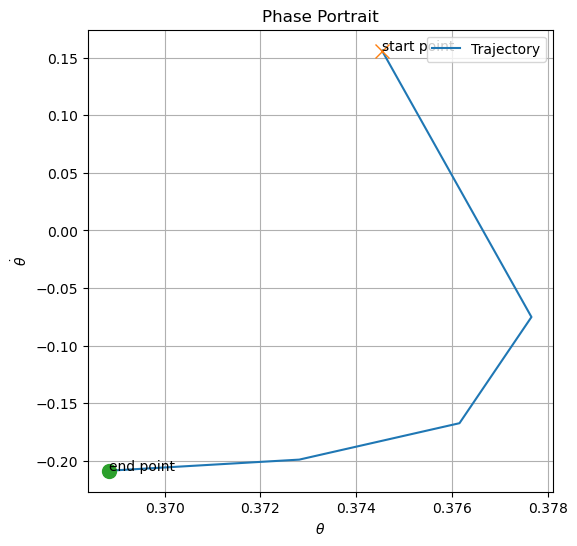

First 3 points: [[ 0.3745  0.156 ]
 [ 0.3777 -0.0752]
 [ 0.3762 -0.1673]]
Last 3 points: [[ 0.3762 -0.1673]
 [ 0.3728 -0.1989]
 [ 0.3688 -0.2086]]


In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(x[:, 0], x[:, 1], label='Trajectory')
# Plot start point with cross marker and label
plt.plot(x[0][0], x[0][1], 'x', markersize=10, linewidth=2)
plt.text(x[0][0], x[0][1], 'start point')

# Plot end point with circle marker and label
plt.plot(x[-1][0], x[-1][1], 'o', markersize=10, linewidth=2)
plt.text(x[-1][0], x[-1][1], 'end point')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.title('Phase Portrait')
plt.grid(True)
plt.legend()
plt.show()

print(f"First 3 points: {x[:3,:]}")
print(f"Last 3 points: {x[-3:,:]}")

In [ ]:
for name, param in lyapunov_nn.named_parameters():
    print(f"name: {name}, param shape: {param.shape}, param dtype: {param.data.dtype}")
    print(param)

name: R, param shape: torch.Size([2, 2]), param dtype: torch.float32
Parameter containing:
tensor([[1.5540, 0.3709],
        [0.0000, 1.1553]], requires_grad=True)
